In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm
import warnings
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
warnings.filterwarnings('ignore')
#한글 깨짐방지
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [3]:
path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission  = pd.read_csv(path + 'submission.csv')
merge_df = pd.concat([train,test])

## 전처리

In [4]:
#그냥 합산했을때 음수 발생하는 경우
d_sum = train.groupby(['date','store_id'])['amount'].sum().reset_index()
d_sum[d_sum['amount']<0]

,date,store_id,amount
34,2016-08-01,138,-180
1504,2016-08-04,1478,-11250
5810,2016-08-15,1683,-35
5823,2016-08-15,1753,-75
5881,2016-08-16,216,-1295
...,...,...,...
473957,2018-07-25,36,-500
476119,2018-07-27,513,-300
478867,2018-07-30,956,-295
479213,2018-07-30,1669,-250


In [6]:
def del_minus(df):
    '''음수값을 처리하기 위함
    음수값을 처리할때 조건은, 동일 store_id, card_id이어야하며
    날짜는 minus보다 이전 날짜
    금액은 minus보다 큰 금액이어야 함

    위 조건을 만족하는 row가 여러개일 경우
    가장 최근의 날짜를 선택하되, 그 날짜가 이미 선택되어 있다면
    보다 이전날짜를 탐색하고, matching되지 않는다면 따로 분류

    속도를 원활하게 하기 위해 diction에 저장후 plus_amount_df와 매칭
    '''
    df['DT'] = pd.to_datetime(df['date']+" "+df['time'])
    minus_amount_df = df[df.amount<0][['DT','store_id','card_id','amount']]
    plus_amount_df = df[df.amount>0][['DT','store_id','card_id','amount']]

    err_dic = dict()
    not_match = []
    check_list = []
    err_dic[470565] = 0
    for i in tqdm(range(minus_amount_df.shape[0])):
        error_index = np.nan #초기화
        minus_index = minus_amount_df.iloc[i].name
        minus_card = minus_amount_df.iloc[i].card_id 
        minus_store = minus_amount_df.iloc[i].store_id
        minus_DT = minus_amount_df.iloc[i].DT
        minus_amount = minus_amount_df.iloc[i].amount

        try :
            range_df = plus_amount_df[plus_amount_df.store_id == minus_store] #동일 상점
            range_df = range_df[range_df.card_id == minus_card] #동일 카드
            range_df = range_df[range_df.DT <= minus_DT] #이전날짜
            range_df = range_df[range_df.amount.apply(lambda x : x >= abs(minus_amount))] #보다 큰 금액
            big_df = range_df[range_df.amount.apply(lambda x : x > abs(minus_amount))] #보다 큰 금액
            same_df = range_df[range_df.amount.apply(lambda x : x == abs(minus_amount))] #동일한 금액
        except :
            not_match.append(minus_index)
            pass

        #동일한 금액이 있는 경우
        if len(same_df)>=1:
            same_index = same_df.index
            error_index = same_index.max()  #최근날짜의 index를 추출
            if error_index in err_dic.keys(): #그 index가 이미 key값을 가지고 있는지 확인
                same_index = list(same_index)
                same_index.reverse()
                for dex in same_index[1:]: 
                    error_index = dex
                    if error_index not in err_dic.keys(): #key에 없는 값을 찾았다면 중단
                        break
                if error_index in err_dic.keys(): #모든 인덱스를 비교하고도 key값에 있다면 not_match에 저장
                    error_index = np.nan
                    not_match.append(minus_index)
            try :
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except :
                pass

        #금액보다 더 큰 금액
        elif len(big_df)>= 1:
            big_index = big_df.index
            error_index = big_index.max()
            if error_index in err_dic.keys():
                big_index = list(big_index)
                big_index.reverse()
                for dex in big_index[1:]:
                    error_index = dex
                    if error_index not in err_dic.keys(): 
                        break
                if error_index in err_dic.keys():
                    error_index = np.nan
                    not_match.append(minus_index)
            try :
                err_dic[error_index] = minus_amount
                check_list.append(error_index)
            except :
                pass
        else : 
            not_match.append(minus_index) #매칭되는 것이 없다면 not_match에 넣어둔다 

    #최종정리
    plus_amount_df = df[df.amount>0]
    fin_minus= pd.DataFrame(index= err_dic.keys(),data=err_dic.values(), columns= ['minus']) 
    plus_amount_df = pd.merge(plus_amount_df,fin_minus,left_index=True, right_index=True,how = 'left')
    plus_amount_df['minus'].fillna(0,inplace = True)
    plus_amount_df['amount'] = plus_amount_df['amount'] + plus_amount_df['minus']
    plus_amount_df.drop('minus',axis=1,inplace=True)        
    return plus_amount_df

In [7]:
new_test = del_minus(test)
new_train = del_minus(train)

In [112]:
# new_train 중 전체 거래일이 100일 이하인경우 학습에 사용불가
new_train['date'] = pd.to_datetime(new_train['date'])
gap_check = new_train.groupby('store_id')['date'].agg(['min','max'])
gap = (gap_check['max']-gap_check['min']).apply(lambda x : x.days)
gap.name = 'gap'
row_count = new_train.groupby('store_id')['date'].count()
gap = pd.concat([gap,row_count],axis=1)

del_id = gap.loc[(gap['gap']<130)|(gap['date']<29)].index
clean_new_train = new_train[~(new_train.store_id.isin(del_id))]

In [115]:
print(f'기본 트레인 길이 : {new_train.shape[0]}, 기본트레인 상점수 : {new_train.store_id.nunique()}')
print(f'clean 트레인 길이 : {clean_new_train.shape[0]}, clean 트레인 상점수 : {clean_new_train.store_id.nunique()}')
print(f'길이 차이 : {new_train.shape[0] - clean_new_train.shape[0]},상점수 차이 : {new_train.store_id.nunique() - clean_new_train.store_id.nunique()}')

기본 트레인 길이 : 3319195, 기본트레인 상점수 : 1716
clean 트레인 길이 : 3280499, clean 트레인 상점수 : 1389
길이 차이 : 38696,상점수 차이 : 327


In [117]:
#상위 5개 값을 제거한다,이렇게함으로써 아웃라이어제거가능
def del_top5(df):
    all_top5 = []
    for i in tqdm(df.store_id.unique()):
        top5 = list(df[df.store_id == i].amount.sort_values(ascending=False).head(5).index)
        all_top5.append(top5)

    del_index = [y for x in all_top5 for y in x]
    df = df.loc[~(df.index.isin(del_index))]
    
    return df

In [118]:
new_train = del_top5(clean_new_train)

In [123]:
i = clean_new_train.store_id.unique()[302]
i

391

In [131]:
sample = new_train[clean_new_train.store_id == i]

In [132]:
sample

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,DT
974359,391,2016-09-20,18:10:31,2893befd05,232.0,NaN,1,0,2016-09-20 18:10:31
974360,391,2016-09-21,17:23:19,a17cde5c62,69.0,NaN,2,0,2016-09-21 17:23:19
974361,391,2016-09-22,18:17:02,44f191b704,162.0,NaN,3,0,2016-09-22 18:17:02
974362,391,2016-09-22,18:27:54,8ee6db1ed2,226.0,NaN,3,0,2016-09-22 18:27:54
974363,391,2016-09-22,18:30:01,89de8fe3ac,319.0,NaN,3,0,2016-09-22 18:30:01
...,...,...,...,...,...,...,...,...,...
975556,391,2018-07-28,13:02:43,6cd3c2ab8c,50.0,NaN,5,0,2018-07-28 13:02:43
975557,391,2018-07-29,10:25:33,220f5b821b,65.0,NaN,6,0,2018-07-29 10:25:33
975558,391,2018-07-30,12:58:59,53723a6f43,60.0,NaN,0,0,2018-07-30 12:58:59
975559,391,2018-07-30,18:57:48,cacea970f5,200.0,NaN,0,0,2018-07-30 18:57:48


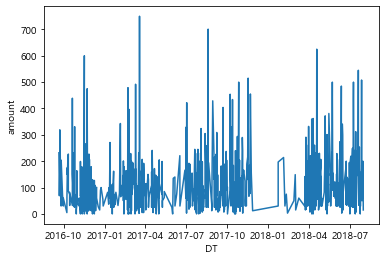

In [133]:
sns.lineplot(y = sample.amount, x = sample.DT)

### fbprophet적용
* 기초적용

In [86]:
train_grouped = new_train.groupby(['date','store_id'])['amount'].sum().reset_index()

In [87]:
train_grouped.store_id.nunique()

1716

### 각 store_id별로 적용후 rmse 비교

In [8]:
Train = True

In [90]:
#하루로 묶어서 진행
train_grouped = new_train.groupby(['date','store_id'])['amount'].mean().reset_index()
y_reals = []
y_preds = []
for i in tqdm(train_grouped.store_id.unique()[:20]):
    sample = train_grouped[train_grouped.store_id ==i]
    sample.drop('store_id',axis=1,inplace=True)
    
    if Train :
        sample['date'] = pd.to_datetime(sample['date'])
        sample.index= sample['date']
        sample.columns = ['ds','y']
        
        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
        
    #예측
    m = Prophet(changepoint_prior_scale=0.05)
    m.fit(train)
    future = m.make_future_dataframe(periods=100)
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [100]:
train_grouped = new_train[['store_id','DT','amount']]

ValueError: Dataframe has less than 2 non-NaN rows.

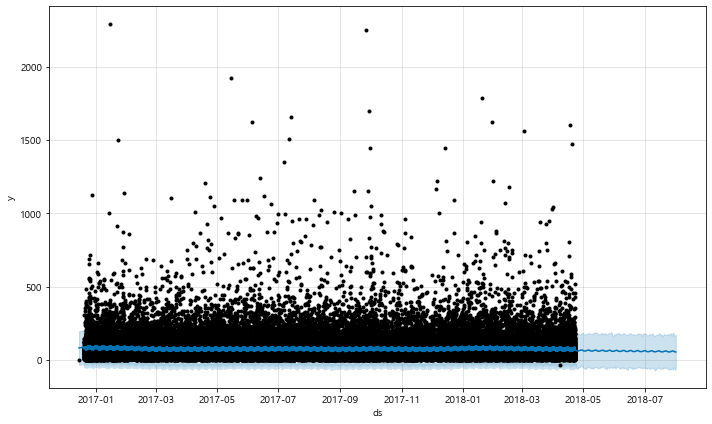

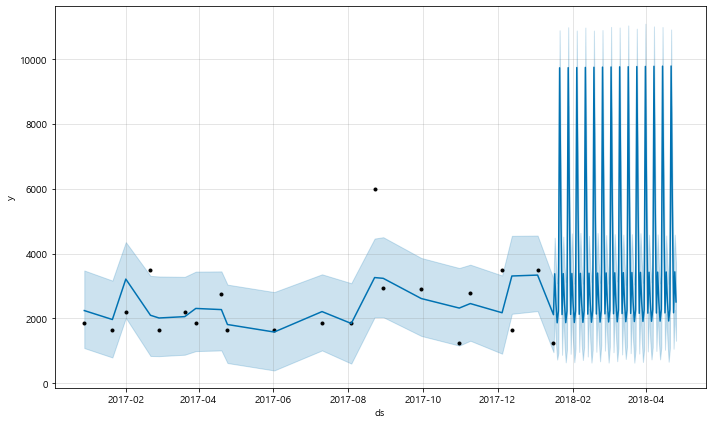

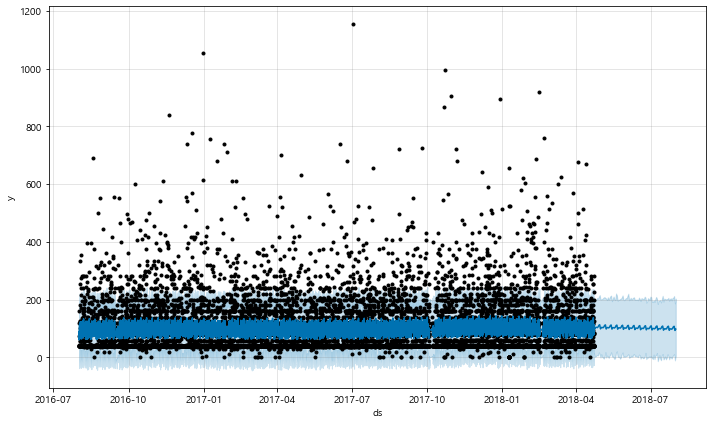

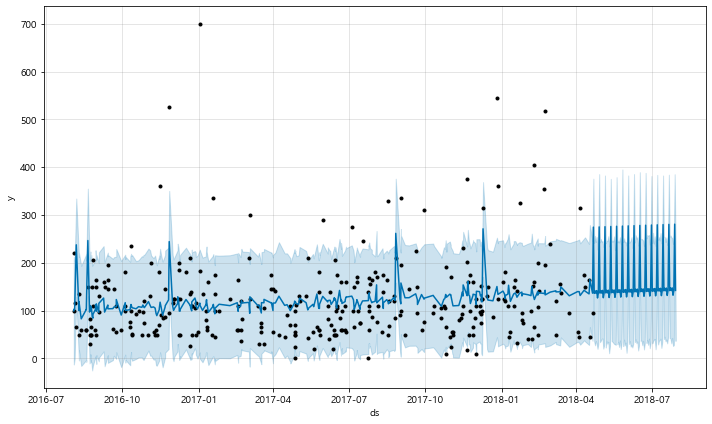

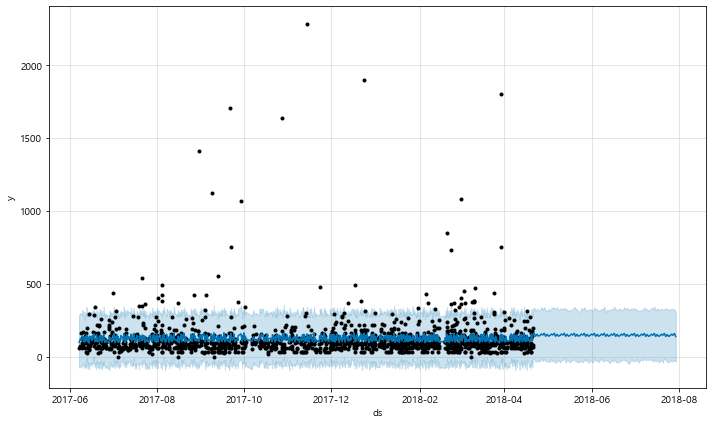

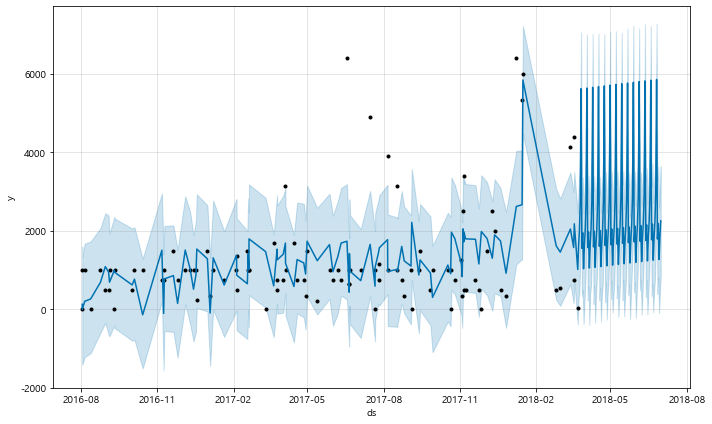

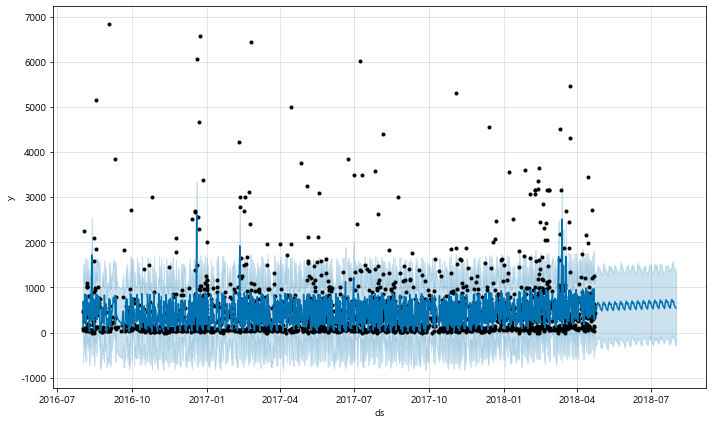

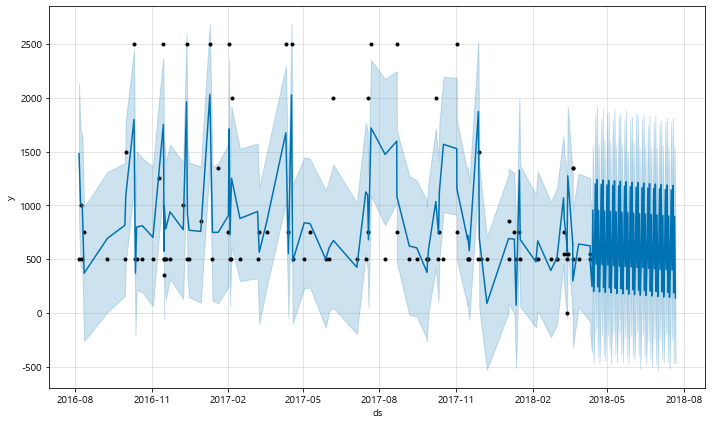

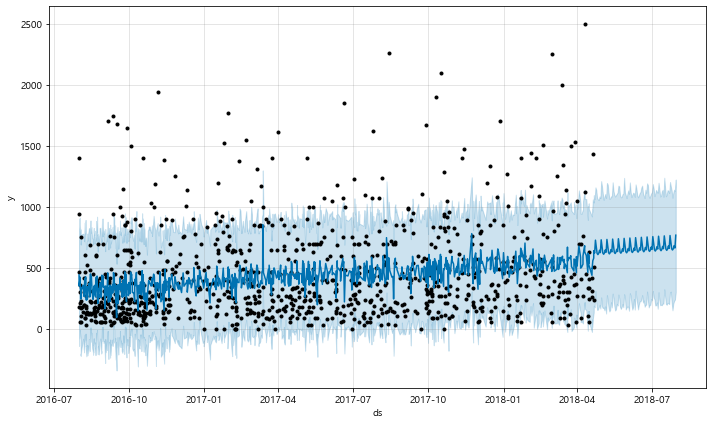

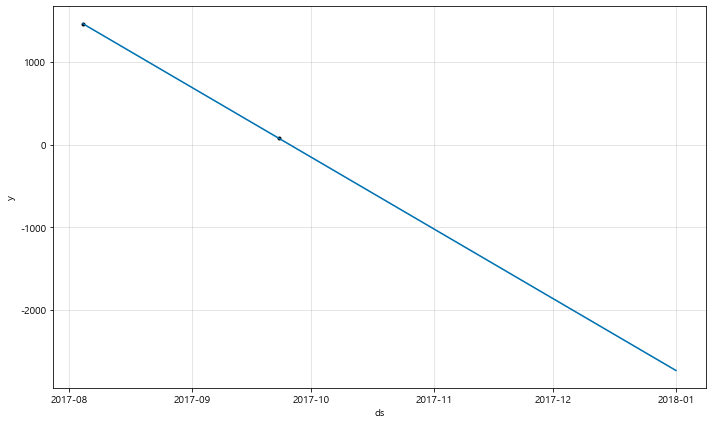

In [106]:
train_grouped = new_train[['store_id','DT','amount']]
y_reals = []
y_preds = []
for i in tqdm(train_grouped.store_id.unique()[:20]):
    sample = train_grouped[train_grouped.store_id ==i]
    sample.drop('store_id',axis=1,inplace=True)
    
    if Train :
#         sample['date'] = pd.to_datetime(sample['date'])
        sample.index= sample['DT']
        sample.columns = ['ds','y']
        
        answer = sample.last('100D')
        train = sample[sample['ds'] < answer['ds'].iloc[0]]
        y_real = answer['y'].sum()
        y_reals.append(y_real)
        
    #예측
    m = Prophet(changepoint_prior_scale=0.05)
    m.fit(train)
    future = m.make_future_dataframe(periods=100)
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    y_pred = forecast.iloc[-100:, :].yhat.sum()
    y_preds.append(y_pred)

### 원자료에서 확인

In [129]:
i = clean_new_train.store_id.unique()[302]
i

391

In [130]:
sample = clean_new_train[clean_new_train.store_id == i]

In [29]:
new_train['date'] = pd.to_datetime(new_train['date'])
new_train[(new_train.store_id ==575)&(new_train['date'] == sample.y.idxmax().date())]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,DT
1360171,575,2017-06-03,22:12:10,7cb658f113,500.0,NaN,5,0,2017-06-03 22:12:10


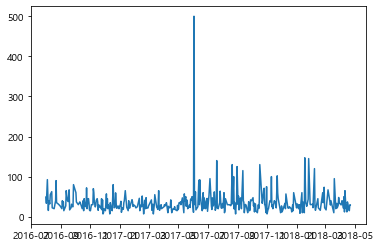

In [17]:
plt.plot(train['y'])

In [338]:
answer = sample.last('100D')

In [339]:
y_real = answer['y'].sum()
y_real

2555.0

In [340]:
m = Prophet(changepoint_prior_scale=0.001)
m.fit(train)

In [341]:
future = m.make_future_dataframe(periods=100)

In [342]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
493,2018-07-27,-1.392136,-88.106815,88.446949,-1.392242,-1.392036,1.078417,1.078417,1.078417,1.078417,1.078417,1.078417,0.0,0.0,0.0,-0.313719
494,2018-07-28,-1.531535,-85.271560,89.414658,-1.531643,-1.531433,4.370020,4.370020,4.370020,4.370020,4.370020,4.370020,0.0,0.0,0.0,2.838485
495,2018-07-29,-1.670934,-97.564392,76.288750,-1.671044,-1.670830,-6.514213,-6.514213,-6.514213,-6.514213,-6.514213,-6.514213,0.0,0.0,0.0,-8.185147
496,2018-07-30,-1.810333,-99.675094,77.431186,-1.810444,-1.810227,-9.442130,-9.442130,-9.442130,-9.442130,-9.442130,-9.442130,0.0,0.0,0.0,-11.252463
497,2018-07-31,-1.949731,-87.904250,85.388840,-1.949845,-1.949623,-0.028792,-0.028792,-0.028792,-0.028792,-0.028792,-0.028792,0.0,0.0,0.0,-1.978524


In [343]:
y_pred = forecast.iloc[-100:, :].yhat.sum()

In [344]:
y_pred

485.5795682676206

In [345]:
np.sqrt(mean_squared_error([y_real],[y_pred]))

2069.4204317323793

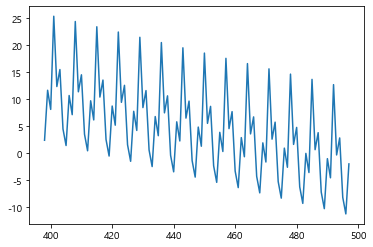

In [346]:
plt.plot(forecast.iloc[-100:, :].yhat)

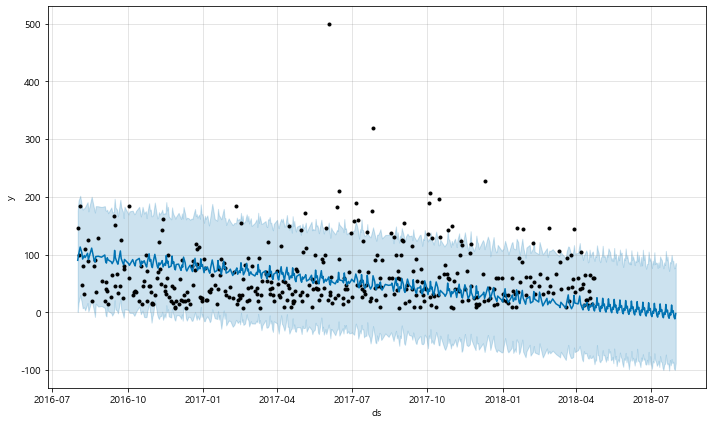

In [347]:
fig1 = m.plot(forecast)

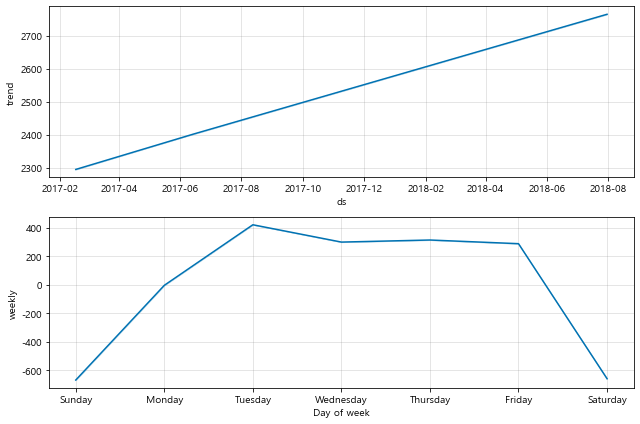

In [279]:
fig2 = m.plot_components(forecast)

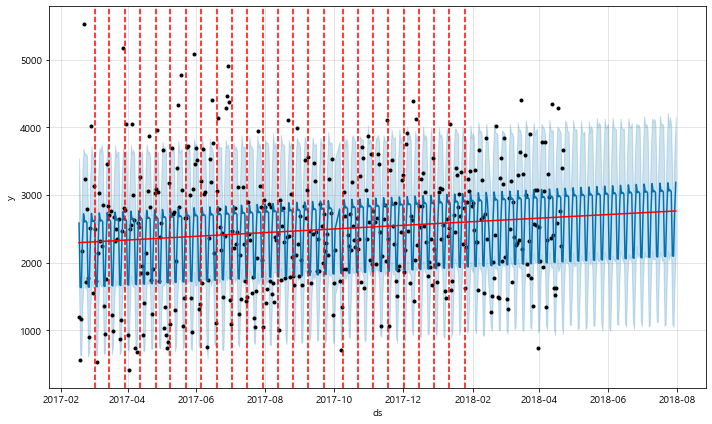

In [277]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0)
plt.show()

### ??? 오류발견
* 매칭되는것이 있음에도 불구하고 안됨

In [104]:
i = 154877
minus_index = minus_amount_df.loc[i].name
minus_card = minus_amount_df.loc[i].card_id 
minus_store = minus_amount_df.loc[i].store_id
minus_DT = minus_amount_df.loc[i].DT
minus_amount = minus_amount_df.loc[i].amount

#plus와 minus의 store_id 와 card_id가 같으면서 날짜가 이전인경우 (각 조건을 나눠서 하는게 속도가 빠름)
try :
    range_df = plus_amount_df[plus_amount_df.store_id == minus_store] #동일 상점
    range_df = range_df[range_df.card_id == minus_card] #동일 카드
    range_df = range_df[range_df.DT <= minus_DT] #이전날짜
    range_df = range_df[range_df.amount.apply(lambda x : x >= abs(minus_amount))] #보다 큰 금액
    big_df = range_df[range_df.amount.apply(lambda x : x > abs(minus_amount))] #보다 큰 금액
    same_df = range_df[range_df.amount.apply(lambda x : x == abs(minus_amount))] #동일한 금액
except :
    not_match.append(minus_index)
    pass

In [105]:
range_df

,DT,store_id,card_id,amount
154865,2017-05-25 03:26:51,39,c95d8a616d,62
154866,2017-05-25 03:27:28,39,c95d8a616d,62
154867,2017-05-25 03:32:18,39,c95d8a616d,62
154868,2017-05-25 03:33:14,39,c95d8a616d,62


In [106]:
#동일한 금액이 있는 경우
if len(same_df)>=1:
    same_index = same_df.index
    error_index = same_index.max()  #최근날짜의 index를 추출
    if error_index in err_dic.keys(): #그 index가 이미 key값을 가지고 있는지 확인
        same_index = list(same_index)
        same_index.reverse()
        for dex in same_index[1:]: 
            error_index = dex
            if error_index not in err_dic.keys():
                break
        if error_index in err_dic.keys(): #모든 인덱스를 비교하고도 key값에 있다면 not_match에 저장
            error_index = np.nan
            not_match.append(minus_index)
    try :
        err_dic[error_index] = minus_amount
        check_list.append(error_index)
    except :
        pass

In [108]:
error_index

154867

In [107]:
err_dic[error_index]

-62

In [110]:
minus_amount_df.loc[not_match]

,DT,store_id,card_id,amount
400700,2016-08-01 17:56:07,138,65be030b0f,-180
400700,2016-08-01 17:56:07,138,65be030b0f,-180
553095,2016-08-16 19:53:30,216,8a3dc45eaa,-915
702984,2016-08-02 12:08:26,284,3c71002f18,-197
702984,2016-08-02 12:08:26,284,3c71002f18,-197
1200075,2016-08-01 18:43:39,508,7e74575056,-330
1200075,2016-08-01 18:43:39,508,7e74575056,-330
1886600,2016-08-29 14:12:16,958,610fa6d878,-1590
1886600,2016-08-29 14:12:16,958,610fa6d878,-1590
1886601,2016-08-29 14:12:29,958,610fa6d878,-50


In [111]:
s_id = 958
c_id = '610fa6d878'

In [112]:
p_day = plus_amount_df[(plus_amount_df.store_id == s_id)&(plus_amount_df.card_id == c_id)]['DT'].iloc[0]
plus_amount_df[(plus_amount_df.store_id == s_id)&(plus_amount_df.card_id == c_id)]

,DT,store_id,card_id,amount
1886603,2016-08-29 15:14:06,958,610fa6d878,1640
1886604,2016-08-29 15:14:42,958,610fa6d878,31
1886605,2016-08-29 15:21:57,958,610fa6d878,56


In [30]:
m_day = minus_amount_df[(minus_amount_df.store_id == 39)&(minus_amount_df.card_id == 'c95d8a616d')]['DT'].iloc[0]
minus_amount_df[(minus_amount_df.store_id == 39)&(minus_amount_df.card_id == 'c95d8a616d')]

,DT,store_id,card_id,amount
154871,2017-05-25 23:19:28,39,c95d8a616d,-62
154872,2017-05-25 23:19:28,39,c95d8a616d,-62
154877,2017-05-26 14:39:27,39,c95d8a616d,-62
154878,2017-05-26 14:39:30,39,c95d8a616d,-62


### 검증

In [14]:
i = 929475

In [15]:
check_store = plus_amount_df.loc[i]['store_id']
check_card = plus_amount_df.loc[i]['card_id']
check_amount = plus_amount_df.loc[i]['amount']
check_DT = plus_amount_df.loc[i]['DT']
plus_amount_df.loc[i]

DT          2017-03-30 14:32:49
store_id                    370
card_id              46a88eb161
amount                   135980
Name: 929475, dtype: object

In [17]:
range_df= minus_amount_df[(minus_amount_df.store_id == check_store)&(minus_amount_df.card_id == check_card)]

In [19]:
plus_amount_df[(plus_amount_df.store_id == check_store)&(plus_amount_df.card_id == check_card)]

,DT,store_id,card_id,amount
929475,2017-03-30 14:32:49,370,46a88eb161,135980
929477,2017-04-17 16:01:00,370,46a88eb161,89180
929478,2017-04-18 13:03:18,370,46a88eb161,52000
929479,2017-04-18 13:03:55,370,46a88eb161,52000
929482,2017-05-17 10:47:41,370,46a88eb161,50000
...,...,...,...,...
929594,2017-10-26 16:25:11,370,46a88eb161,50000
929595,2017-10-26 16:25:41,370,46a88eb161,50000
929596,2017-10-26 16:26:13,370,46a88eb161,50000
929597,2017-10-26 16:26:44,370,46a88eb161,50000


In [18]:
range_df

,DT,store_id,card_id,amount
929489,2017-06-08 11:44:35,370,46a88eb161,-135980
929490,2017-06-12 18:27:24,370,46a88eb161,-52000
929491,2017-06-12 18:28:09,370,46a88eb161,-52000
929502,2017-07-03 15:42:08,370,46a88eb161,-89180
929503,2017-07-04 21:39:08,370,46a88eb161,-10313
929504,2017-07-04 21:40:03,370,46a88eb161,-10313
929505,2017-07-05 13:00:47,370,46a88eb161,-10313
929506,2017-07-05 13:01:48,370,46a88eb161,-10313
929507,2017-07-05 13:03:05,370,46a88eb161,-1650
929508,2017-07-05 22:57:22,370,46a88eb161,-50000


In [35]:
if len(range_df)>= 1:
    range_index = range_df.index
    error_index = range_index.max()
    print(error_index)
    if error_index in err_dic.keys():
        range_index = list(range_index)
        range_index.reverse()
        for dex in range_index[1:]:
            error_index = dex
            print(error_index)
            if error_index in err_dic.keys():
                pass

82548


### 검증

In [41]:
i = 400700

In [42]:
check_store = minus_amount_df.loc[i]['store_id']
check_card = minus_amount_df.loc[i]['card_id']
check_amount = minus_amount_df.loc[i]['amount']
check_DT = minus_amount_df.loc[i]['DT']
minus_amount_df.loc[i]

DT          2016-08-01 17:56:07
store_id                    138
card_id              65be030b0f
amount                     -180
Name: 400700, dtype: object

In [43]:
minus_amount_df[(minus_amount_df.store_id == check_store)&(minus_amount_df.card_id == check_card)]

,DT,store_id,card_id,amount
400700,2016-08-01 17:56:07,138,65be030b0f,-180


In [44]:
plus_amount_df[(plus_amount_df.store_id == check_store)&(plus_amount_df.card_id == check_card)]

,DT,store_id,card_id,amount


In [278]:
range_df = plus_amount_df[plus_amount_df.store_id == check_store]
range_df = range_df[range_df.card_id == check_card]
range_df = range_df[range_df.DT <= check_DT]
#     range_df = plus_amount_df[(plus_amount_df.store_id == minus_store)&(plus_amount_df.card_id == minus_card)&(plus_amount_df.DT <= minus_DT)]

target = range_df[range_df.amount.apply(lambda x : x >= abs(minus_amount))]

In [274]:
target[target.amount.isin([abs(check_amount)])]

,DT,store_id,card_id,amount


In [270]:
target[target.amount.isin([abs(check_amount)])].index.max()

82421